# Constant Bias Removal

In [1]:
import os
import csv
import numpy as np

def removeBias(fileName):
    data_file = open(os.getcwd() + "/data/" + fileName + '/VID_' + fileName + 'gyro.csv',  'r')
    no_bias_file = open(os.getcwd() + "/data/" + fileName + '/VID_' + fileName + 'gyro_no_bias.csv',  'w+', newline="")
    data_reader = csv.reader(data_file)
    writer = csv.writer(no_bias_file)
    ### These values are average biases of 12 gyroscope recordings
    x_avg, y_avg, z_avg = 0.002959729290667013, -0.0013153975512994055, 0.0025717275792764486
    for new_row in data_reader:
        x_no_bias = np.float64(new_row[0]) - x_avg
        y_no_bias = np.float64(new_row[1]) - y_avg
        z_no_bias = np.float64(new_row[2]) - z_avg
        writer.writerow([x_no_bias, y_no_bias, z_no_bias, int(new_row[3])])

    data_file.close()
    no_bias_file.close()

### For a specific file

In [16]:
removeBias("20220714_120859")

# Compute Quaternion From Gyroscope

In [3]:
import csv
import math
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import mathutils

def quaternionProduct(q1, q2):
    w0, x0, y0, z0 = q1
    w1, x1, y1, z1 = q2
    return np.array([-x1 * x0 - y1 * y0 - z1 * z0 + w1 * w0,
                     x1 * w0 + y1 * z0 - z1 * y0 + w1 * x0,
                     -x1 * z0 + y1 * w0 + z1 * x0 + w1 * y0,
                     x1 * y0 - y1 * x0 + z1 * w0 + w1 * z0], dtype=np.float64)

def quaternionNormalize(pose_initial, q_grad, dt=1/400):
    quat = mathutils.Quaternion(np.asarray(pose_initial, dtype=np.float64) + dt * q_grad)
    return quat.normalized()


def euler_from_quaternion(x, y, z, w):
        """
        Convert a quaternion into euler angles (roll, pitch, yaw)
        roll is rotation around x in radians (counterclockwise)
        pitch is rotation around y in radians (counterclockwise)
        yaw is rotation around z in radians (counterclockwise)
        source: https://stackoverflow.com/questions/56207448/efficient-quaternions-to-euler-transformation
        """
        if w == 1:
            return 0,0,0
        roll_x = np.arctan2(y*z + x*w, 0.5 - z*z - w*w)
        pitch_y = np.arcsin(2.0 * (y*w - x*z))
        yaw_z = np.arctan2(2*(w*z+x*y), 1-2*(y*y+z*z))
          
        return roll_x, pitch_y, yaw_z # in radians

def computeQuaternion(fileName, displayGraph=False, getEulerAngle=False, useNoBias=False):
    quat_gyro = [0] * 4
    pose_initial = [0] * 4
    t_init, t_final, counter = 0, 0, 0
    dt = 1/400

    if useNoBias:
        data_file = open(os.getcwd() + "/data/" + fileName + '/VID_' + fileName + 'gyro_no_bias.csv',  'r')
        quat_file = open(os.getcwd() + "/data/" + fileName + '/VID_' + fileName + 'quaternion_no_bias.csv',  'w+', newline="")
    else:
        data_file = open(os.getcwd() + "/data/" + fileName + '/VID_' + fileName + 'gyro.csv',  'r')
        quat_file = open(os.getcwd() + "/data/" + fileName + '/VID_' + fileName + 'quaternion.csv',  'w+', newline="")

    data_reader = csv.reader(data_file)
    writer = csv.writer(quat_file)

    if displayGraph and getEulerAngle:
        quat_euler_file = open(os.getcwd() + "/data/" + fileName + '/VID_' + fileName + 'quaternion_euler.csv',  'w+', newline="")
        euler_writer = csv.writer(quat_euler_file)
        roll_list, pitch_list, yaw_list = list(), list(), list()

    q = []
    q_list = list()

    #CSV Headers: qw, qx, qy, qz, time, gx, gy, gz
    for row in data_reader:
        if counter == 0:
            writer.writerow([1,0,0,0,int(row[3]), float(row[0]), float(row[1]), float(row[2])])
            q = [1,0,0,0]
            q_list.append(q)
        else:
            """
            This quaternion approach is from: https://stackoverflow.com/questions/39441900/how-use-raw-gryoscope-data-s-for-calculating-3d-rotation
            This implementation is also used in the Madgwick Filter for orientation
            """
            quat_gyro = list(np.array([0.0, float(row[0]), float(row[1]), float(row[2])]).astype(np.float64))
            q_grad = 0.5 * quaternionProduct(pose_initial, quat_gyro)
            new_pose = quaternionNormalize(pose_initial,q_grad,dt=dt)
            # delta_quat = [1, 0.5*dt*float(row[0]), 0.5*dt*float(row[1]), 0.5*dt*float(row[2])]
            # new_pose = quaternionProduct(pose_initial, delta_quat)
            writer.writerow([new_pose[0], new_pose[1], new_pose[2], new_pose[3], int(row[3]), float(row[0]), float(row[1]), float(row[2])])
            pose_initial, q = new_pose, new_pose
            q_list.append(q_grad)
        counter += 1

        if displayGraph:
            if getEulerAngle:
                """Quaternion to Euler"""
                roll,pitch,yaw = euler_from_quaternion(x=q[1],y=q[2],z=q[3],w=q[0])
                roll_list.append(roll)
                pitch_list.append(pitch)
                yaw_list.append(yaw)

                euler_writer.writerow([roll*(-180/math.pi), pitch*(180/math.pi), yaw*(180/math.pi), int(row[3])])
            """Time"""
            t_final = int(row[3])
            if t_init == 0:
                t_init = int(row[3])


    if displayGraph and getEulerAngle:
        x = np.linspace(0, abs(t_final - t_init)/1e9, num=counter)
        plt.plot(x, np.asarray(roll_list)*(-180/math.pi), color="g", label="x")
        plt.plot(x, np.asarray(pitch_list)*(180/math.pi), color="r", label="y")
        plt.plot(x, np.asarray(yaw_list)*(180/math.pi), color="b", label="z")
        plt.xlabel('time (s)')
        plt.ylabel('orientation (degree)') 
        plt.legend()
        plt.title("Rotation of the file: " + fileName)
        plt.show()
        quat_euler_file.close()
    elif displayGraph and not getEulerAngle:
        x = np.linspace(0, abs(t_final - t_init)/1e9, num=counter)
        # plt.plot(x, np.asarray(q_list)[:,0], color="g", label="w")
        plt.plot(x, np.asarray(q_list)[:,1], color="r", label="x")
        # plt.plot(x, np.asarray(q_list)[:,2], color="b", label="y")
        # plt.plot(x, np.asarray(q_list)[:,3], color="y", label="z")
        plt.xlabel('time (s)')
        plt.ylabel('quaternion value (units)') 
        plt.legend()
        plt.title("Rotation of the file: " + fileName)
        plt.show()

    data_file.close()
    quat_file.close()   

## For a specific file

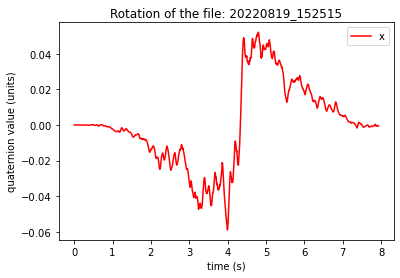

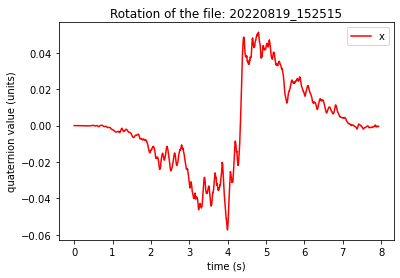

In [49]:
fileName = "20220819_152515"
computeQuaternion(fileName=fileName, displayGraph=True, getEulerAngle=False, useNoBias=False)
computeQuaternion(fileName=fileName, displayGraph=True, getEulerAngle=False, useNoBias=True)

"""
Exceptions:
20220713_113701
20220713_114353
20220713_134934
20220713_134943
""";

## For entire dataset

In [4]:
import os 
import time
from IPython.display import clear_output


dataset_list = os.listdir(os.getcwd() + "/data")

for file in dataset_list:
    if ".mp4" in file:
        continue
    if file == ".DS_Store":
        continue
    if file == "irstv":
        continue
    computeQuaternion(fileName=file, displayGraph=False, getEulerAngle=False, useNoBias=False)
    computeQuaternion(fileName=file, displayGraph=False, getEulerAngle=False, useNoBias=True)

# Visualize

## 3D Visualization

In [ ]:
import visualize
visualize.main(fileName="20220719_164557")

## 2D Graph Visualization

In [22]:
import csv
import matplotlib.pyplot as plt

def showQuaternionGraph(fileName):
    bias_file = open(os.getcwd() + "/test_data_for_drift/" + fileName + '/VID_' + fileName + '_sync_quaternion.csv',  'r')
    no_bias_file = open(os.getcwd() + "/test_data_for_drift/" + fileName + '/VID_' + fileName + '_sync_quaternion_no_bias.csv',  'r')
    
    bias_reader = csv.reader(bias_file)
    no_bias_reader = csv.reader(no_bias_file)
    t_final, t_init, counter, counter2 = 0,0,0,0

    bias_list, no_bias_list = list(), list()

    for row in bias_reader:
        if counter == 0:
            counter+=1
            continue
        bias_list.append([float(row[0]), float(row[1]), float(row[2]), float(row[3])])
        """Time"""
        t_final = float(row[4])
        if t_init == 0:
            t_init = float(row[4])
        counter+=1
    for row in no_bias_reader:
        if counter2 == 0:
            counter2=1
            continue
        no_bias_list.append([float(row[0]), float(row[1]), float(row[2]), float(row[3])])


    x = np.linspace(0, abs(t_final - t_init)/1e9, num=counter-1)

    quaternionGraphHelper(x=x, axis_name="q_w", bias_list=np.asarray(bias_list)[:,0], no_bias_list=np.asarray(no_bias_list)[:,0])
    quaternionGraphHelper(x=x, axis_name="q_x", bias_list=np.asarray(bias_list)[:,1], no_bias_list=np.asarray(no_bias_list)[:,1])
    quaternionGraphHelper(x=x, axis_name="q_y", bias_list=np.asarray(bias_list)[:,2], no_bias_list=np.asarray(no_bias_list)[:,2])
    quaternionGraphHelper(x=x, axis_name="q_z", bias_list=np.asarray(bias_list)[:,3], no_bias_list=np.asarray(no_bias_list)[:,3])

def quaternionGraphHelper(x, axis_name, bias_list, no_bias_list):
    plt.plot(x, bias_list, color="r", label= axis_name + " (with bias)")
    plt.plot(x, no_bias_list, color="b", label=axis_name + " (without bias)")
    plt.xlabel('time (s)')
    plt.ylabel('quaternion value (unit)') 
    plt.legend()
    plt.title("Rotation of the file: " + fileName)
    plt.show()

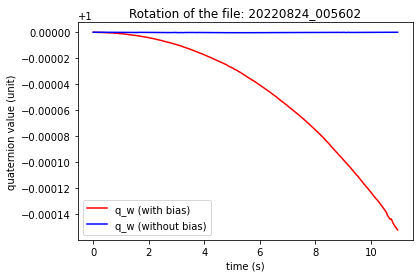

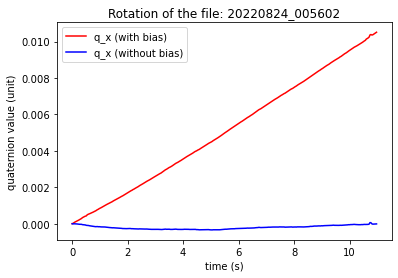

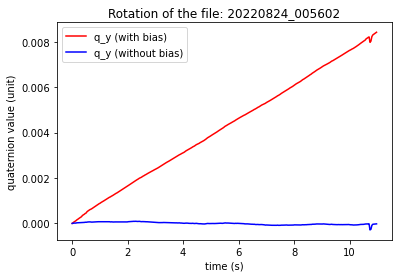

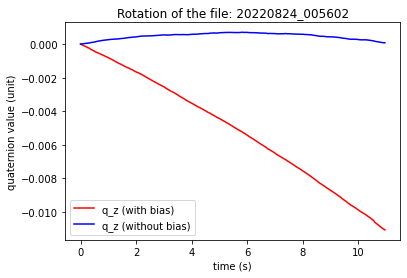

In [23]:
showQuaternionGraph("20220823_154539")

# ~~Get Bias From Gyroscope~~ (Archived)

In [29]:
import csv
import numpy as np

def getBias(fileName):
    data_file = open(os.getcwd() + "/data/" + fileName + '/VID_' + fileName + 'gyro.csv',  'r')
    no_bias_file = open(os.getcwd() + "/data/" + fileName + '/VID_' + fileName + 'gyro_no_bias.csv',  'w+', newline="")

    data_reader = csv.reader(data_file)
    writer = csv.writer(no_bias_file)

    gyrox_sum, gyroy_sum, gyroz_sum, counter = 0, 0, 0, 0

    for row in data_reader:
        gyrox_sum += np.float64(row[0])
        gyroy_sum += np.float64(row[1])
        gyroz_sum += np.float64(row[2])
        counter += 1

    x_avg = np.float64(gyrox_sum / counter)
    y_avg = np.float64(gyroy_sum / counter)
    z_avg = np.float64(gyroz_sum / counter)
    return [x_avg, y_avg, z_avg]

"""Gyro biases on stationary phone"""
# [0.0018855560077923677, -0.0015147849860639457, 0.001998133136795269]
# [0.0023541866129046297, -0.0014704887938013964, 0.0021177975037650803]
# [0.002637841621087466, -0.0014374401634911355, 0.0021901422757161183]
# [0.0029067682437616186, -0.0013219803739327352, 0.0024111160944757576]
##### New recordings
# [0.001971349950307151, -0.001162270641305506, 0.002392530052851403]
# [0.0027322209821872435, -0.00132237795789546, 0.00255874371921226]
# [0.003168177621475571, -0.001274775783804188, 0.0026026346329374277]
# [0.0033315814470002655, -0.0011213576486272226, 0.0026787650082680855]
# [0.003441995499439723, -0.0012577668530153476, 0.0028299777581907008]
# [0.0033766217978679603, -0.001299766506476647, 0.0027707176244282116]
# [0.003700882228675842, -0.0012949534505377796, 0.0031801607622099206]
# [0.004009569475504318, -0.0013068074566415027, 0.003130012382467148]

### Get average bias

In [12]:
arr = np.asarray([[0.0018855560077923677, -0.0015147849860639457, 0.001998133136795269],
[0.0023541866129046297, -0.0014704887938013964, 0.0021177975037650803],
[0.002637841621087466, -0.0014374401634911355, 0.0021901422757161183],
[0.0029067682437616186, -0.0013219803739327352, 0.0024111160944757576],
[0.001971349950307151, -0.001162270641305506, 0.002392530052851403],
[0.0027322209821872435, -0.00132237795789546, 0.00255874371921226],
[0.003168177621475571, -0.001274775783804188, 0.0026026346329374277],
[0.0033315814470002655, -0.0011213576486272226, 0.0026787650082680855],
[0.003441995499439723, -0.0012577668530153476, 0.0028299777581907008],
[0.0033766217978679603, -0.001299766506476647, 0.0027707176244282116],
[0.003700882228675842, -0.0012949534505377796, 0.0031801607622099206],
[0.004009569475504318, -0.0013068074566415027, 0.003130012382467148]])

print([sum(arr[:,0])/len(arr),sum(arr[:,1])/len(arr),sum(arr[:,2])/len(arr)])

[0.002959729290667013, -0.0013153975512994055, 0.0025717275792764486]


# ~~Compute orientation from Gyro~~ (Archived)

In [13]:
import csv
import math
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

def computeOrientation(fileName, displayGraph=False, useNoBias=False):
    gyroX, gyroY, gyroZ, time = [], [], [], []
    dt = 1/400 #400Hz
    data_file = None
    orientation_file = None
    
    if useNoBias:
        data_file = open(os.getcwd() + "/test_data_for_drift/" + fileName + '/VID_' + fileName + 'gyro_no_bias.csv',  'r')
        orientation_file = open(os.getcwd() + "/test_data_for_drift/" + fileName + '/VID_' + fileName + 'orientation_no_bias.csv',  'w+', newline="")
    else:
        data_file = open(os.getcwd() + "/test_data_for_drift/" + fileName + '/VID_' + fileName + 'gyro.csv',  'r')
        orientation_file = open(os.getcwd() + "/test_data_for_drift/" + fileName + '/VID_' + fileName + 'orientation.csv',  'w+', newline="")

    data_reader = csv.reader(data_file)
    writer = csv.writer(orientation_file)

    t_init, t_final, counter = 0, 0, 0
    
    for row in data_reader:
        gyroX.append(float(row[0]))
        gyroY.append(float(row[1]))
        gyroZ.append(float(row[2]))
        time.append(int(row[3]))
        
        t_final = int(row[3])
        counter += 1
        if t_init == 0:
            t_init = int(row[3])


    x = np.linspace(0, abs(t_final - t_init)/1e9, num=counter)
    X_int = integrate.cumtrapz(gyroX, dx=dt, initial=0)
    Y_int = integrate.cumtrapz(gyroY, dx=dt, initial=0)
    Z_int = integrate.cumtrapz(gyroZ, dx=dt, initial=0)

    if displayGraph:
        plt.plot(x, X_int*(180/math.pi), color="g", label="x")
        plt.plot(x, Y_int*(180/math.pi), color="r", label="y")
        plt.plot(x, Z_int*(180/math.pi), color="b", label="z")
        plt.xlabel('time (s)')
        plt.ylabel('orientation (degree)') 
        plt.legend()
        plt.title("Rotation of the file: " + fileName)
        plt.show()


    for i in range(len(time)):
        writer.writerow([X_int[i]*(180/math.pi), Y_int[i]*(180/math.pi), Z_int[i]*(180/math.pi), time[i], gyroX[i], gyroY[i], gyroZ[i]])

    data_file.close()
    orientation_file.close()

## For specific file

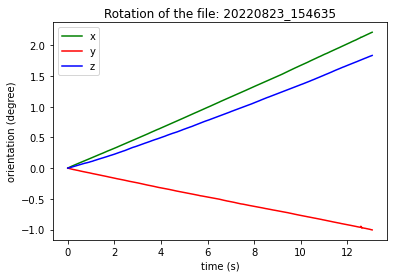

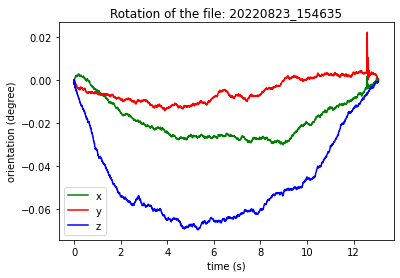

In [26]:
fileName = "20220823_154635"
computeOrientation(fileName=fileName, displayGraph=True, useNoBias=False)
computeOrientation(fileName=fileName, displayGraph=True, useNoBias=True)

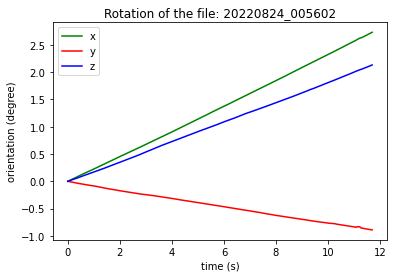

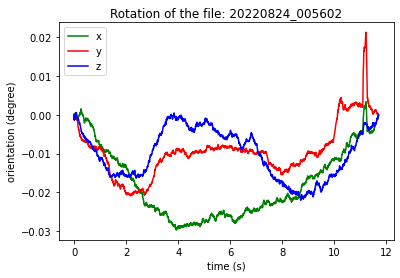

In [19]:
fileName = "20220824_005602"
computeOrientation(fileName=fileName, displayGraph=True, useNoBias=False)
computeOrientation(fileName=fileName, displayGraph=True, useNoBias=True)

## For entire dataset

In [9]:
import os 
import time
from IPython.display import clear_output

displayGraph = False

dataset_list = os.listdir(os.getcwd() + "/data")

for file in dataset_list:
    if file == ".DS_Store":
        continue
    if ".mp4" in file:
        continue
    if "20220927" not in file:
        continue
    computeOrientation(fileName=file, displayGraph=displayGraph)
    if displayGraph:
        time.sleep(1)
        os.system('clear')
        clear_output(wait=True)

# ~~Sync orientation to video frame~~ (Archived)

In [11]:
import csv
import math
import numpy as np
import cv2

def processData(fileName, sensorType):
    time_file, data_file, data_processed = "", "", ""

    try:
        time_file = open(os.getcwd() + "/data/" +  fileName+ '/VID_' + fileName  + '_imu_timestamps.csv', 'r')
        data_file = open(os.getcwd() + "/data/" +  fileName+ '/VID_' + fileName  +  sensorType + '.csv', 'r')
        data_processed = open(os.getcwd() + "/data/" +  fileName+ '/VID_' + fileName  + "_sync_" + sensorType + '.csv',  'w+', newline="")
    except:
        print("Some files in " + fileName + " are missing")
        return
    time_reader = csv.reader(time_file)
    data_reader = csv.reader(data_file)

    writer = csv.writer(data_processed)
    writer.writerow(["Rot_X (deg)", "Rot_Y (deg)", "Rot_Z (deg)", "Gyro_Time (ns)", "Gyro_X", "Gyro_Y", "Gyro_Z"])

    """Loop through the time data file and the gyro file; Then add the ones in gyro that have closest timestamp to the timestamp file"""
    #Time list
    time_list = list(time_reader)
    frame_counter = 0

    """GYRO/ACC/MAG"""
    data_processed = list() #This will be the list we will export as a CSV
    data_set = set() #Only add matched timestamp here

    """First entry"""
    first_orientation = []

    for row in data_reader:
        if frame_counter == len(time_list):
            break

        target_time = int(time_list[frame_counter][0]) #This will get the target timestamp
        if len(data_processed) == 0:
            data_processed.append(row)
            continue
        
        #   If the current time from gyro_csv file has a smaller time difference than that in the
        #   data_processed list. Then we replace
        if (abs(int(row[3]) - target_time) < abs(int(data_processed[-1][3]) - target_time)):
            #Check set to see if previous time is already matched; We don't want it to be matched already
            if int(data_processed[-1][3]) not in data_set:
                #Replace with timestamp that has smaller time diff
                data_processed[-1] = row 
        else:
            #Add last element in the processed list to the data_set to confirm it's been matched
            frame_counter += 1
            data_set.add(int(data_processed[-1][3]))
            # orientation_row = [float(data_processed[-1][0]),float(data_processed[-1][1]),float(data_processed[-1][2])]
            orientation_row = np.array(data_processed[-1]).astype(float)
            if first_orientation == []:
                first_orientation = np.array(orientation_row)
            orientation_row[0] -= first_orientation[0]
            orientation_row[1] -= first_orientation[1]
            orientation_row[2] -= first_orientation[2]
            orientation_row[3] = data_processed[-1][3]
            orientation_row[4] = data_processed[-1][4]
            orientation_row[5] = data_processed[-1][5]
            orientation_row[6] = data_processed[-1][6]

            #Add this element to the CSV file as well
            writer.writerow(orientation_row)
            #Then add current row to data_processed
            data_processed.append(row)

    assert(len(data_processed)-1 == len(time_list))

    time_file.close()
    data_file.close()


## For specific file

In [15]:
processData(fileName="20220714_121005", sensorType="orientation")

c:\Users\PeterNg\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:56: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


## For entire dataset

In [12]:
import os 
import time
from IPython.display import clear_output


dataset_list = os.listdir(os.getcwd() + "/data")

for file in dataset_list:
    if file == ".DS_Store":
        continue
    if ".mp4" in file:
        continue
    if "20220927" not in file:
        continue
    processData(fileName=file, sensorType="orientation")

c:\Users\PeterNg\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:56: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
